# Imports, parameters and scenarios

In [10]:
"""
Simplified quite a lot, but based mostly on the formulation in Luna et al. (2017), see
Mixed-Integer-Linear-Programming-Based Energy Management System for Hybrid PV-Wind-Battery Microgrids
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7492611  
"""
import random
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import math

# -------------------------------
# Parameters
# -------------------------------

# LOCATION
LOCATIONS = ["kenya", "canada", "madeira"]
LOCATION = LOCATIONS[2] 

# Cost parameters
FC_s = 300      # Cost per m² of solar panels
FC_w = 4.3 * 1_300_000      # Cost per wind turbine
FC_h = 1_500_000    # Fixed cost per river turbine
FC_b = 115*5      # Cost per kWh of battery capacity

"""
CASE STUDIES: 
Assumption 1: $300/m2 cost of solar panels. 
Assumption 2: $115/kWh * 5 https://www.statista.com/statistics/883118/global-lithium-ion-battery-pack-costs/ rough estimate: multiply by 5 for installation cost
"""

# Solar Parameters
MAX_IRRADIANCE = 1000  # W/m² at peak conditions
SOLAR_EFFICIENCY = 0.20  # Typical efficiency for commercial solar panels
PERFORMANCE_RATIO = 0.75  # Account for various system losses

# Wind Parameters
AIR_DENSITY = 1.225  # kg/m3 at sea level, 15C
WIND_CP = 0.35  # Power coefficient 
TURBINE_DIAMETER = 151   # meters - can be adjusted
TURBINE_AREA = math.pi * (TURBINE_DIAMETER/2)**2 # sweeping area (m2)
RATED_WIND_SPEED = 10 # m/s, typical rated wind speed

RATED_POWER_WIND = 4_300_000 # Maximum wattage of installed turbine
CUT_IN_WIND_SPEED = 5 # m/s where wind turbine begins generating
CUT_OFF_WIND_SPEED = 25 # m/s where wind turbine stops generating to reduce risk of damage

"""
CASE STUDIES: Wind power parameters for each site and cost.
According to https://weatherguardwind.com/how-much-does-wind-turbine-cost-worth-it/: $1.3 million per MW installed capacity. We use this for the prices.


See https://www.thewindpower.net/turbine_en_39_ecotecnia_80-1.6.php for wind turbine data.
For more realstic scenarios we need 1) The price per turbine, 2) The installation costs 
(which includes 2.1 existing infrastructure, 2.2 location and so on) and 3) the maintenance costs.
These limitations are discussed further in the project report. 

Kenya: # 36 meters https://www.thewindpower.net/turbine_en_1124_ades_ades-200.php
    36 meter diameter, 200 kW rated power, rated wind speed 10.5 m/s. Cut-in-speed 4, cut-off 25

Canada: # 19.4 meters https://www.thewindpower.net/turbine_en_337_bonus_b19-120.php
    19.4 meter diameter, 120 kW rated power, rated wind speed (estimate) 10. Cut-in (estimate) 5, cut-off (estimate 25)

Madeira: # 151 meters https://www.thewindpower.net/turbine_en_1896_aerovide_am-4.3-151.php
    151 meter diameter, 4300 kW rated power, rated wind speed 10. Cut-in (estimate) 5, cut-off (estimate) 25
"""

# Hydro Parameters
MASS_FLOW_CAPACITY_TURBINE = 6000 # mass flow of water capacity kg/s
g = 9.81 # gravitational constant
H_NET = 15 # Net head, height difference in meters from start of river to generator point
ETA = 0.93 # Generator efficiency
MAX_TURBINES = 10 # Manually tunable turbine parameter - How many turbines fit in the river?

"""
CASE STUDIES: Hydro power parameters for each site and cost.

Kenya: https://www.fstgenerator.com/no/50kw-micro-vertical-kaplan-turbine-generator-for-low-head-hydropower-product/
    Parameters: 2500-4700 kg/s, 85% efficiency, 5 meter net head. Price ~ $100_000 (estimate based on similar Chinese products with prices) for turbine

Madeira: https://www.fstgenerator.com/no/750kw-kaplan-turbine-product/
    Parameters: 6000 kg/s, 93% efficiency, 15 meter net head. Price ~ $150_000 (estimate) for turbine

We assume that installation cost is 10x of this for both sites. 
"""

# Battery parameter
BATTERY_EFFICIENCY = 0.85 # Manually tunable efficiency parameter

# Scenarios

In [11]:
# -----------------------------
# Load Weather Data
# -----------------------------
weather_df = pd.read_excel(
    "Weatherdata.xlsx",
    sheet_name="Ark1",        # Change to your actual sheet name if needed
    skiprows=1,
    parse_dates=["time"]        # Ensure 'time' is parsed as a datetime
)

# Rename columns for clarity (adjust based on your file’s exact column headers)
weather_df.rename(columns={
    "Wind (m/s)":  "wind_canada_m_s",
    "Solar (W/m²)": "solar_canada_w_m2",
    "Wind (m/s).1":  "wind_kenya_m_s",
    "Solar (W/m²).1": "solar_kenya_w_m2",
    "Wind (m/s).2":  "wind_madeira_m_s",
    "Solar (W/m²).2": "solar_madeira_w_m2"
}, inplace=True)

# Sort rows by time and set it as the DataFrame index
weather_df.sort_values(by="time", inplace=True)
weather_df.set_index("time", inplace=True)

# -----------------------------
# Load Demand Data
# -----------------------------
demand_df = pd.read_excel(
    "Data Demand Energy Allocation EIT-year.xlsx",
    sheet_name="Year",        # Change to your actual sheet name if needed
    parse_dates=["Time"],        # Ensure 'Time' is parsed as a datetime
)

# Rename columns for clarity (adjust based on your file’s exact column headers)
demand_df.rename(columns={
    "Real Demand Canada":   "real_demand_canada",
    "Real Demand Africa":   "real_demand_kenya",
    "Real Demand Madeira":   "real_demand_madeira",
    "Random Demand Canada": "random_demand_canada",
    "Random Demand Africa": "random_demand_kenya",
    "Random Demand Madeira": "random_demand_madeira"
}, inplace=True)

# Sort rows by time and set it as the DataFrame index
demand_df.sort_values(by="Time", inplace=True)
demand_df.set_index("Time", inplace=True)

HOURS = len(weather_df)  # 365 days
T = list(range(1, HOURS))  # Hours 1 to 24*365

# -----------------------------------------------------
# Build scenario dictionaries from the DataFrames
# -----------------------------------------------------
# Dictionaries for solar irradiance (watt/m²), wind power (watt), hydro production, and demand (watt)
S = {}
W = {}
H = {}
Q = {}

# For each time period, extract the scenario data:
for i, time in enumerate(demand_df.index, start=1):
    # Solar: Use the 'solar_{LOCATION}_w_m2' column directly.
    solar_irradiation = weather_df.loc[time, f"solar_{LOCATION}_w_m2"]
    S[i] = solar_irradiation * SOLAR_EFFICIENCY * PERFORMANCE_RATIO
    
    # Wind: Get the wind speed in km/h from the weather DataFrame, then convert to m/s.
    wind_speed_ms = weather_df.loc[time, f"wind_{LOCATION}_m_s"]

    # Set generation to 0 if wind_speed_ms is less than the cut-in speed.
    if wind_speed_ms >= CUT_IN_WIND_SPEED and wind_speed_ms <= CUT_OFF_WIND_SPEED:
        wind_power_theoretical = 0.5 * AIR_DENSITY * WIND_CP * TURBINE_AREA * (wind_speed_ms**3)
    else:
        wind_power_theoretical = 0

    # Max rated power generation
    if wind_power_theoretical >= RATED_POWER_WIND:
        wind_power_theoretical = RATED_POWER_WIND
    
    W[i] = wind_power_theoretical # Then this is the per turbine theoretical generation per hour

    # Demand: Use the 'random_demand_{LOCATION}' column from the demand DataFrame.
    Q[i] = demand_df.loc[time, f"random_demand_{LOCATION}"]

    H[i] = MASS_FLOW_CAPACITY_TURBINE * g * H_NET * ETA # Assumption: constant for all i

# Plotting generation and demand profiles:

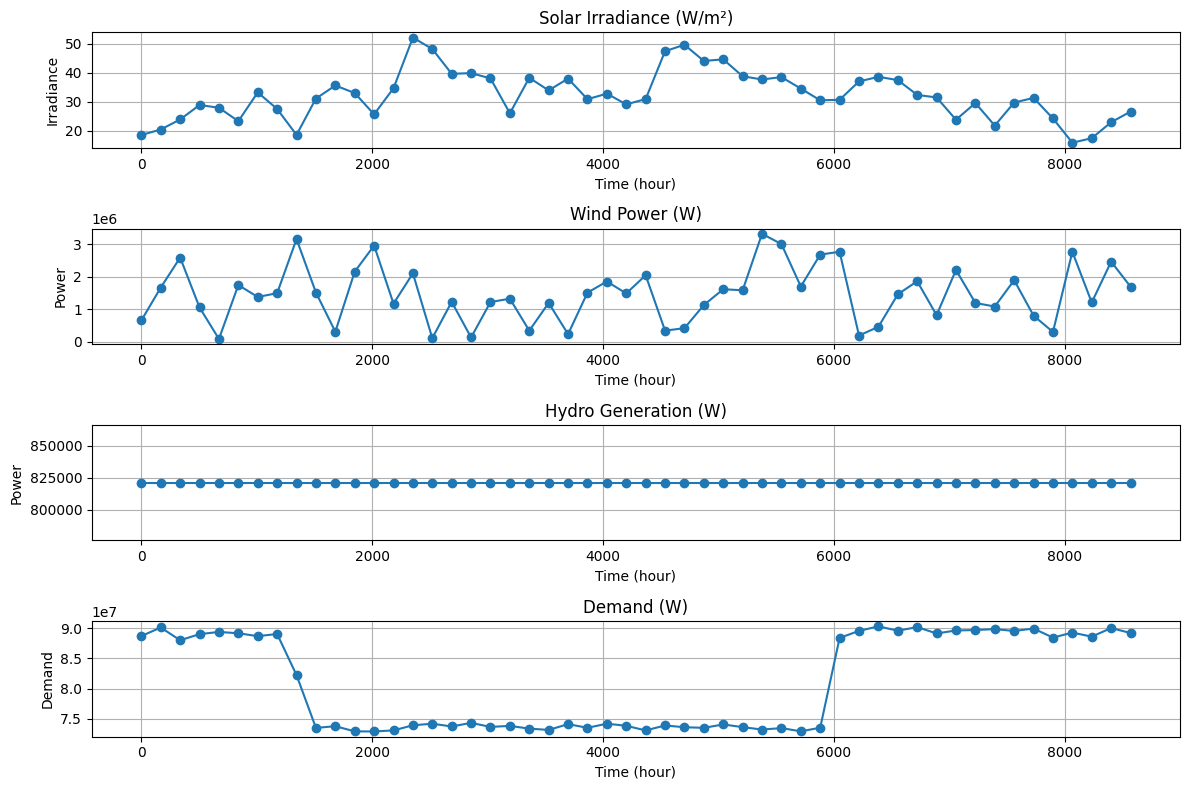

In [12]:
import matplotlib.pyplot as plt

step = 168  # 168 hours in a week
weeks = len(T) // step  # Total number of full weeks

T_reduced = [T[i * step] for i in range(weeks)]  # One timestamp per week

S_reduced = [sum(S[t] for t in T[i * step:(i + 1) * step]) / step for i in range(weeks)]
W_reduced = [sum(W[t] for t in T[i * step:(i + 1) * step]) / step for i in range(weeks)]
H_reduced = [sum(H[t] for t in T[i * step:(i + 1) * step]) / step for i in range(weeks)]
Q_reduced = [sum(Q[t] for t in T[i * step:(i + 1) * step]) / step for i in range(weeks)]

# --- Plotting ---
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(T_reduced, S_reduced, marker='o', linestyle='-')
plt.title('Solar Irradiance (W/m²)')
plt.xlabel('Time (hour)')
plt.ylabel('Irradiance')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(T_reduced, W_reduced, marker='o', linestyle='-')
plt.title('Wind Power (W)')
plt.xlabel('Time (hour)')
plt.ylabel('Power')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(T_reduced, H_reduced, marker='o', linestyle='-')
plt.title('Hydro Generation (W)')
plt.xlabel('Time (hour)')
plt.ylabel('Power')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(T_reduced, Q_reduced, marker='o', linestyle='-')
plt.title('Demand (W)')
plt.xlabel('Time (hour)')
plt.ylabel('Demand')
plt.grid(True)

plt.tight_layout()
plt.show()

# Modelling part:

Nb! Must tune big M to 10e10 if use Madeira example. For other two cases, 10e6 works fine.

In [13]:
# -------------------------------
# Data & Scenario Generation
# -------------------------------
# Set random seed for reproducibility
random.seed(0)

# Define scenarios (1: low, 2: medium, 3: high)
scenarios = [1, 2, 3]
scenario_prob = {1: 1/3, 2: 1/3, 3: 1/3}  # Equal probability

# Generate scenario-specific dictionaries for Q, S, and H.
# W remains the same across scenarios.
scenarios_Q = {}
scenarios_S = {}
scenarios_H = {}

for omega in scenarios:
    scenarios_Q[omega] = {}
    scenarios_S[omega] = {}
    scenarios_H[omega] = {}
    for t in T:
        if omega == 1:  # Low scenario: -10%
            random_factor = random.normalvariate(0.9, 0.1)
            scenarios_Q[omega][t] = Q[t] * random_factor
            scenarios_S[omega][t] = S[t] * random_factor
            scenarios_H[omega][t] = H[t] * random_factor
        elif omega == 2:  # Medium scenario: base values
            scenarios_Q[omega][t] = Q[t]
            scenarios_S[omega][t] = S[t]
            scenarios_H[omega][t] = H[t]
        elif omega == 3:  # High scenario: +10%
            random_factor = random.normalvariate(1.1, 0.1)
            scenarios_Q[omega][t] = Q[t] * random_factor
            scenarios_S[omega][t] = S[t] * random_factor
            scenarios_H[omega][t] = H[t] * random_factor


# -------------------------------
# Stochastic Gurobi Model
# -------------------------------
m = gp.Model("stochastic_minigrid")

# ---- First-Stage Decision Variables (investment decisions) ----

# Solar panel area (m²)
x_s = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="PV_area_sqm")
# Number of wind turbines
x_w = m.addVar(vtype=GRB.INTEGER, lb=0, name="Wind_turbines")
# Hydro capacity (kW) as an integer decision
x_h = m.addVar(vtype=GRB.INTEGER, lb=0, name="Hydro_capacity")
# Battery capacity (kWh)
x_b = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="Battery_capacity")

# Hydro capacity limit (first-stage constraint)
m.addConstr(x_h <= MAX_TURBINES, name="max_hydro_turbines")

# ---- Second-Stage Decision Variables (operational decisions) ----
# These are defined for each time period t in T and scenario omega in scenarios.
curt_s = m.addVars(T, scenarios, lb=0, name="solar_curtailment")
curt_w = m.addVars(T, scenarios, lb=0, name="wind_curtailment")
curt_h = m.addVars(T, scenarios, lb=0, name="hydro_curtailment")
E_ESS   = m.addVars(T, scenarios, lb=-GRB.INFINITY, name="E_ESS")
SoC     = m.addVars(range(HOURS), scenarios, lb=0, name="State_of_Charge")

y = m.addVars(T, scenarios, vtype=GRB.BINARY, name="surplus_flag")


# -------------------------------
# Constraints (for each scenario and time period)
# -------------------------------
for omega in scenarios:
    for t in T:
        # Curtailment Limits:
        m.addConstr(curt_s[t, omega] <= x_s * scenarios_S[omega][t],
                    name=f"solar_curtailment_limit_{t}_{omega}")
        m.addConstr(curt_w[t, omega] <= x_w * W[t],
                    name=f"wind_curtailment_limit_{t}_{omega}")
        m.addConstr(curt_h[t, omega] <= x_h * scenarios_H[omega][t],
                    name=f"hydro_curtailment_limit_{t}_{omega}")
                    
        # Battery Capacity Constraint:
        m.addConstr(SoC[t, omega] <= x_b, name=f"batt_capacity_{t}_{omega}")
        
        # For t > 0, add battery dynamics and charge/discharge limits.
        if t > 0:
            # Battery state update:
            m.addConstr(
                SoC[t, omega] == SoC[t-1, omega] - BATTERY_EFFICIENCY * E_ESS[t, omega],
                name=f"batt_dyn_{t}_{omega}"
            )
            # Charging limit: when battery is charging (E_ESS negative)
            m.addConstr(
                E_ESS[t, omega] >= - (x_b - SoC[t-1, omega]) / BATTERY_EFFICIENCY,
                name=f"charge_limit_{t}_{omega}"
            )
            # Discharging limit: when battery is discharging (E_ESS positive)
            m.addConstr(
                E_ESS[t, omega] <= SoC[t-1, omega] * BATTERY_EFFICIENCY,
                name=f"discharge_limit_{t}_{omega}"
            )
        
        # Define a helper expression for raw supply:
        supply = (x_s * scenarios_S[omega][t] - curt_s[t, omega] +
                x_w * W[t]                - curt_w[t, omega] +
                x_h * scenarios_H[omega][t] - curt_h[t, omega])

        M = 1e9   # adjust this value as appropriate

        # When y[t,omega] = 1 (i.e. no surplus), we want supply <= Q.
        m.addConstr(supply <= scenarios_Q[omega][t] + M * (1 - y[t, omega]),
                    name=f"supply_constraint_{t}_{omega}")

        # When y[t,omega] = 0 (i.e. surplus), enforce supply >= Q + ε (with a small epsilon)
        epsilon = 1e-3
        m.addConstr(supply >= scenarios_Q[omega][t] + epsilon - M * y[t, omega],
                    name=f"surplus_constraint_{t}_{omega}")
        
        m.addConstr(E_ESS[t, omega] <= M * y[t, omega],
            name=f"battery_discharge_limit_{t}_{omega}")

        # Then the final energy balance includes battery:
        m.addConstr(supply + 1000 * E_ESS[t, omega] == scenarios_Q[omega][t],
                    name=f"energy_balance_{t}_{omega}")

    
    # Initial Battery Constraint (for each scenario)
    m.addConstr(SoC[T[0], omega] == x_b / 2, name=f"init_batt_{omega}")
    # Terminal Battery Constraint (for each scenario)
    m.addConstr(SoC[T[-1], omega] >= x_b / 2, name=f"terminal_batt_{omega}")

# -------------------------------
# Objective Function
# -------------------------------
# Here we only consider the first-stage (investment) costs.
m.setObjective(FC_s * x_s + FC_w * x_w + FC_h * x_h + FC_b * x_b, GRB.MINIMIZE)


# -------------------------------
# Solve and Report
# -------------------------------
m.optimize()

if m.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found:")
    print("Investment Decisions:")
    print(f"  Solar Installation: {x_s.X:.1f} m²")
    print(f"  Wind Turbines:      {int(x_w.X)}")
    print(f"  Hydro Capacity:     {int(x_h.X)} (units)")
    print(f"  Battery Capacity:   {x_b.X:.1f} kWh")
    print(f"Total fixed cost:     {m.objVal:.1f} USD")
else:
    print("No optimal solution was found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 5800X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 289846 rows, 158101 columns and 937828 nonzeros
Model fingerprint: 0x20b6f390
Variable types: 131750 continuous, 26351 integer (26349 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+09]
  Objective range  [3e+02, 6e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 90094 rows and 32466 columns
Presolve time: 2.61s
Presolved: 199752 rows, 125635 columns, 514679 nonzeros
Variable types: 104015 continuous, 21620 integer (21618 binary)

Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Orderin

# Plotting the generation

Weekly average plot:

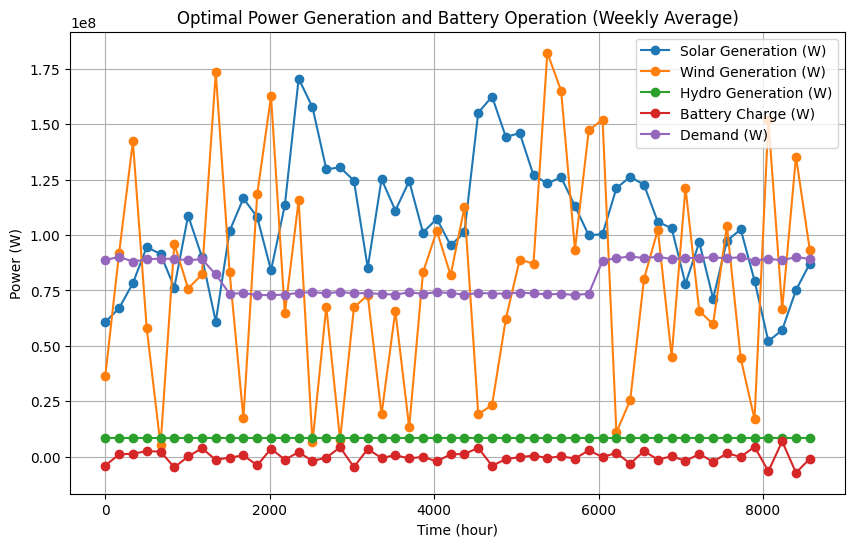

In [14]:
# Compute weekly averages
step = 168  # 168 hours in a week
weeks = len(T) // step  # Total number of full weeks

# Generate weekly time points
T_reduced = [T[i * step] for i in range(weeks)]

# Compute weekly averages for each metric
solar_generation = [sum(x_s.X * S[t] for t in T[i * step:(i + 1) * step]) / step for i in range(weeks)]
wind_generation = [sum(x_w.X * W[t] for t in T[i * step:(i + 1) * step]) / step for i in range(weeks)]
hydro_generation = [sum(x_h.X * H[1] for t in T[i * step:(i + 1) * step]) / step for i in range(weeks)]
battery_charge = [sum(E_ESS[t, 1].X for t in T[i * step:(i + 1) * step]) * 1000 / step for i in range(weeks)]
demand = [sum(Q[t] for t in T[i * step:(i + 1) * step]) / step for i in range(weeks)]

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(T_reduced, solar_generation, marker='o', label="Solar Generation (W)")
plt.plot(T_reduced, wind_generation, marker='o', label="Wind Generation (W)")
plt.plot(T_reduced, hydro_generation, marker='o', label="Hydro Generation (W)")
plt.plot(T_reduced, battery_charge, marker='o', label="Battery Charge (W)")
plt.plot(T_reduced, demand, marker='o', label="Demand (W)")

plt.xlabel("Time (hour)")
plt.ylabel("Power (W)")
plt.title("Optimal Power Generation and Battery Operation (Weekly Average)")
plt.legend()
plt.grid(True)
plt.show()

Currently, a lot of curtailment is happening. We did not impose a cost on curtailing available energy or incentivize ramping up demand (e.g. selling to a grid when not in island mode or turning on industry) when it is low or penalize rapid charging and discharging of the batteries to limit the project scope..

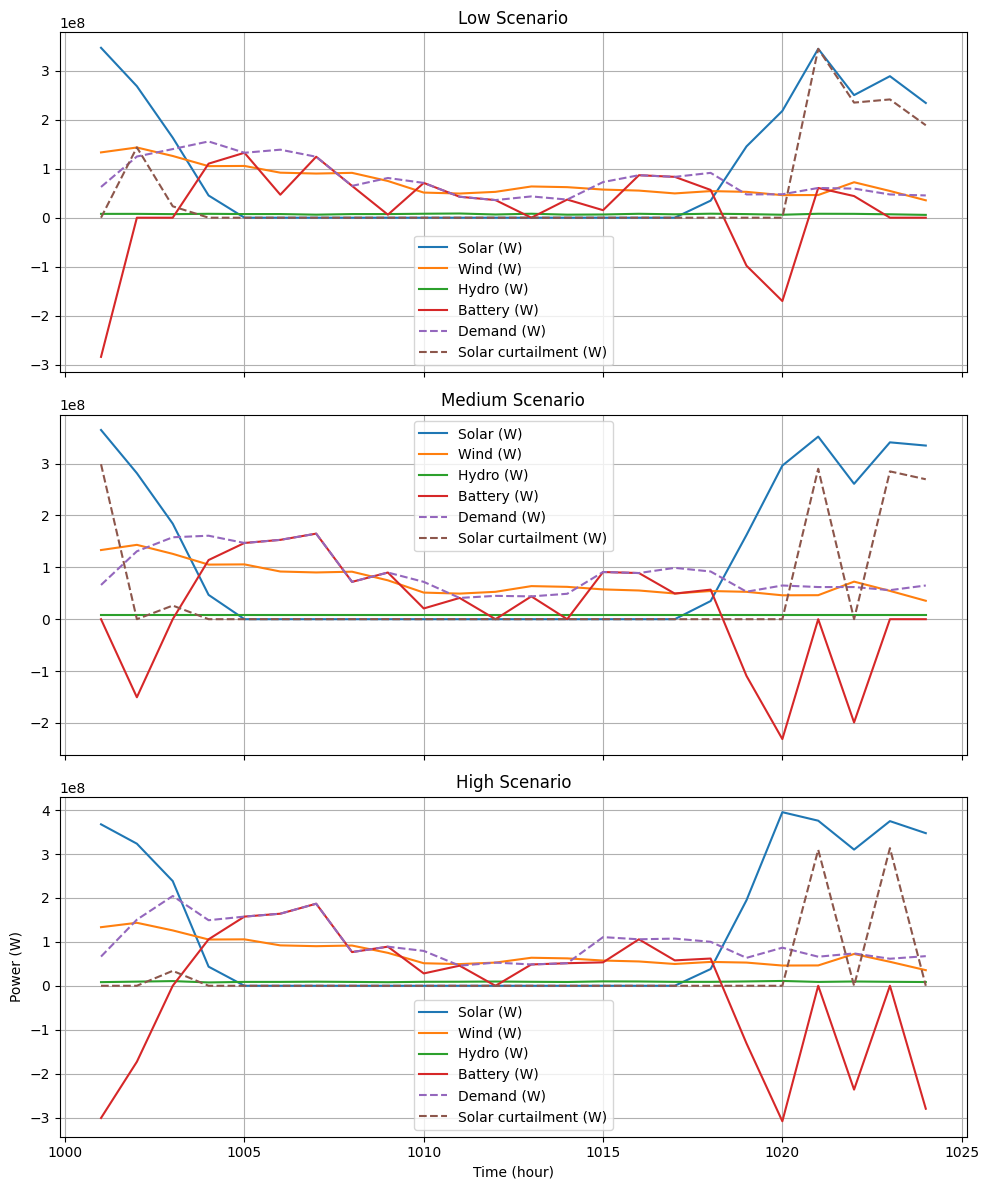

In [15]:
# Define the first week's data range
week_1 = T[1000:1024]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,12), sharex=True)
scenario_labels = {1: "Low", 2: "Medium", 3: "High"}

for idx, omega in enumerate(scenarios):
    ax = axes[idx]
    ax.set_title(f"{scenario_labels[omega]} Scenario")

    # Plot solar, wind, hydro, battery, demand for the scenario
    solar = [x_s.X * scenarios_S[omega][t] for t in week_1]
    wind  = [x_w.X * W[t] for t in week_1]
    hydro = [x_h.X * scenarios_H[omega][t] for t in week_1]
    batt  = [E_ESS[t, omega].X * 1000 for t in week_1]
    dem   = [scenarios_Q[omega][t] for t in week_1]
    cur_s = [curt_s[t, omega].X for t in week_1]

    ax.plot(week_1, solar, label="Solar (W)")
    ax.plot(week_1, wind,  label="Wind (W)")
    ax.plot(week_1, hydro, label="Hydro (W)")
    ax.plot(week_1, batt,  label="Battery (W)")
    ax.plot(week_1, dem,   label="Demand (W)", linestyle="--")
    ax.plot(week_1, cur_s,   label="Solar curtailment (W)", linestyle="--")


    ax.legend()
    ax.grid(True)

plt.xlabel("Time (hour)")
plt.ylabel("Power (W)")
plt.tight_layout()
plt.show()
